In [1]:
# IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from pmdarima import auto_arima, ARIMA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score
from sklearn.tree import plot_tree

## Data preparation

<img src="images/system-design.png" alt="Stock analytics system design">

Let's recap our whole process in stock analytics. First, we've learned about fundamental of the market and where to find its indicators including other related information (data sources). Next, you've learned the tools that use to gather and do basic analysis on the market such as stock scaner. From those two processes, we are likely to get basic understanding about the market as well as the dataset for doing the next step: Using data to build a strategy and simulation.

However per system design and in some cases, you may need another optional step - Time-series modelling. It is basically the extension of the basic data mining and data analysis, which in my opinion they fall into descriptive and diagnostic analytics according to [analytics maturity](https://medium.com/@milind.bapuji.desai/understanding-the-analytics-maturity-model-84982836b107).

For time-series modelling, it should help answer the next thing about stock analytics, which is "what is likely to happen?"

### Data Dictionary

In the previous module, we end up getting the one flat-file-like dataset. If we want to use it, using the following snippet:

```python
# truncated
df = pd.read_parquet("../02-dataframe-analysis/stocks_df_combined_trunc_2014_2023.parquet.brotli")
```

For thorough analysis, let start with getting dataset from the full version of dataset instead.

In [2]:
df = pd.read_parquet("data/stocks_df_combined_2024_05_07.parquet.brotli")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 221142 entries, 0 to 5426
Columns: 202 entries, Open to growth_btc_usd_365d
dtypes: datetime64[ns](3), float64(128), int32(64), int64(5), object(2)
memory usage: 288.5+ MB


In [4]:
# List unique stocks
nunique_tickers = df.Ticker.nunique()
print(f"The number of unique stocks: {nunique_tickers}")

The number of unique stocks: 33


In [5]:
# List daily start-latest records
df.groupby(["ticker_type", "Ticker"])["Date"].agg(["min", "max", "count"])

min        max  count
ticker_type Ticker                                    
EU          ACN           2001-07-19 2024-05-07   5736
            ASML          1995-03-15 2024-05-07   7338
            CDI.PA        1992-01-27 2024-05-07   8328
            IDEXY         2010-01-20 2024-05-07   3599
            MC.PA         2000-01-03 2024-05-07   6258
            NVO           1981-04-30 2024-05-07  10846
            OR.PA         2000-01-03 2024-05-07   6258
            RMS.PA        2000-01-03 2024-05-07   6258
            SAP           1995-09-18 2024-05-07   7209
            SIE.DE        1996-11-08 2024-05-07   7046
            TTE           1991-10-25 2024-05-07   8193
INDIA       BHARTIARTL.NS 2002-07-01 2024-05-07   5424
            HDB           2001-07-20 2024-05-07   5735
            HINDUNILVR.NS 1996-01-01 2024-05-07   7122
            IBN           2000-03-28 2024-05-07   6066
            INFY          1999-03-11 2024-05-07   6331
            ITC.NS        1996-01-01 2024-05-07   7119
            LICI.NS       2022-05-17 2024-05-07    487
            LT.NS         2002-07-01 2024-05-07   5427
            RELIANCE.NS   1996-01-01 2024-05-07   7119
            SBIN.NS       1996-01-01 2024-05-07   7120
            TCS.NS        2002-08-12 2024-05-07   5395
US          AAPL          1980-12-12 2024-05-07  10941
            AMZN          1997-05-15 2024-05-07   6789
            AVGO          2009-08-06 2024-05-07   3713
            BRK-B         1996-05-09 2024-05-07   7046
            GOOG          2004-08-19 2024-05-07   4963
            JPM           1980-03-17 2024-05-07  11129
            LLY           1972-06-01 2024-05-07  13095
            META          2012-05-18 2024-05-07   3011
            MSFT          1986-03-13 2024-05-07   9615
            NVDA          1999-01-22 2024-05-07   6364
            V             2008-03-19 2024-05-07   4062

In [6]:
# Filter only 25 years of data
df = df[df.Date >= "2000-01-01"]

Note that in production, automated version of the dataset need be updated according to your trading timeframe. This can add up another layer of complexity to our system asking question - "Should it be an updated file (flat-file database), SQL database or other types of database?"

Next, we need to identify which features and target(s) that we would like to use in our time-series modelling.

In [7]:
# Volume; not using price as an absolute value
df["LN_Volume"] = np.where(df["Volume"] == 0, np.nan, np.log(df["Volume"]))

# Growth represented as relative price
GROWTH = [c for c in df.columns if c.startswith("growth_") and "future" not in c]

# Macro indicators
MACRO = ["gdppot_us_yoy", "gdppot_us_qoq", "cpi_core_yoy", "cpi_core_mom", "FEDFUNDS", "DGS1", "DGS5", "DGS10"]

# Technical indicators
TECHNICAL_INDICATORS = ['adx', 'adxr', 'apo', 'aroon_1','aroon_2', 'aroonosc', 'bop', 'cci', 'cmo','dx', 'macd', 'macdsignal', 'macdhist', 'macd_ext', 'macdsignal_ext', 'macdhist_ext', 'macd_fix', 'macdsignal_fix', 'macdhist_fix', 'mfi', 'minus_di', 'mom', 'plus_di', 'dm', 'ppo', 'roc', 'rocp', 'rocr', 'rocr100', 'rsi', 'slowk', 'slowd', 'fastk', 'fastd', 'fastk_rsi', 'fastd_rsi', 'trix', 'ultosc', 'willr', 'ad', 'adosc', 'obv', 'atr', 'natr', 'ht_dcperiod', 'ht_dcphase', 'ht_phasor_inphase', 'ht_phasor_quadrature', 'ht_sine_sine', 'ht_sine_leadsine', 'ht_trendmod', 'avgprice', 'medprice', 'typprice', 'wclprice']
TECHNICAL_PATTERNS = [c for c in df.columns if c.startswith("cdl")]

# User-defined
USER_DEFINED = ["SMA10", "SMA20", "growing_moving_average", "high_minus_low_relative", "volatility", "LN_Volume"]

# Unused
DROP_COLUMNS = ["Year", "Date", "index_x", "index_y", "index", "Quarter", "Adj Close_y", "Open", "High", "Low", "Close", "Adj Close_x"]

/Users/green/miniforge3/envs/stock-market-analytics-zoomcamp/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [8]:
# Numerical features
NUMERICAL_FEATURES = GROWTH + MACRO + TECHNICAL_INDICATORS + TECHNICAL_PATTERNS + USER_DEFINED
df[NUMERICAL_FEATURES].info()

<class 'pandas.core.frame.DataFrame'>
Index: 182675 entries, 3490 to 5426
Columns: 184 entries, growth_1d to LN_Volume
dtypes: float64(121), int32(62), int64(1)
memory usage: 214.6 MB


### Feature Encoding (OHE)

For categorical features, we can use `pd.get_dummies()` to create binary columns.

In [9]:
# Cast type into a str
df["Month"] = df.Month.dt.strftime('%B')
df["Weekday"] = df.Weekday.astype(str)

# Create one-hot encoding for each category in each column
CATEGORICAL_FEATURES = ["Month", "Weekday", "Ticker", "ticker_type"]
dummies_df = pd.get_dummies(df[CATEGORICAL_FEATURES], dtype="int32")

In [10]:
# Dummies
DUMMIES = list(dummies_df.columns)
dummies_df[DUMMIES].info()

<class 'pandas.core.frame.DataFrame'>
Index: 182675 entries, 3490 to 5426
Data columns (total 55 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   Month_April           182675 non-null  int32
 1   Month_August          182675 non-null  int32
 2   Month_December        182675 non-null  int32
 3   Month_February        182675 non-null  int32
 4   Month_January         182675 non-null  int32
 5   Month_July            182675 non-null  int32
 6   Month_June            182675 non-null  int32
 7   Month_March           182675 non-null  int32
 8   Month_May             182675 non-null  int32
 9   Month_November        182675 non-null  int32
 10  Month_October         182675 non-null  int32
 11  Month_September       182675 non-null  int32
 12  Weekday_0             182675 non-null  int32
 13  Weekday_1             182675 non-null  int32
 14  Weekday_2             182675 non-null  int32
 15  Weekday_3             182675 non-null 

In [11]:
# Concatenate dummies
df = pd.concat([df, dummies_df], axis=1).reset_index(drop=True)
df[NUMERICAL_FEATURES + DUMMIES].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182675 entries, 0 to 182674
Columns: 239 entries, growth_1d to ticker_type_US
dtypes: float64(121), int32(117), int64(1)
memory usage: 251.6 MB


Note that in practice you may require to include more combination of features according to "omitted variable bias" from Econometrics, which is a situation where not all relevant variables include in a regression model, leading to biased and inconsistent estimates.

In feature engineering especially feature encoding, there is a simple but powerful technique called feature crosses. This is a combination of various categorical feature like cross product between its one-hot feature vectors. In this example, you may try the combination between september and friday and evaluate whether it could capture (or a better predictor) to your model.

### Correlation Analysis

Pearson correlation coefficient is the value to identify the positive/negative/no linear relationship between two variables. It is considered one of the popular tools for feature selection. As a rule of thumb, you can consider the coefficient as showing the strong/weak/no relation between variables as the following:

* 0.7 <= |r| < 1: strong
* 0.3 <= |r| < 0.7: moderate
* 0 <= |r| < 0.3: weak

In [12]:
# Target(s)
TARGETS = [c for c in df.columns if "future" in c]

In [13]:
# Find pearson correlation coefficient (r)
corr_classification_df = df[NUMERICAL_FEATURES + DUMMIES + TARGETS].corr()["is_positive_growth_5d_future"].sort_values(ascending=False)
corr_regression_df = df[NUMERICAL_FEATURES + DUMMIES + TARGETS].corr()["growth_future_5d"].sort_values(ascending=False)

In [14]:
# List top 10 positive r for classification
print(corr_classification_df.head(10))

is_positive_growth_5d_future    1.000000
growth_future_5d                0.668535
growth_btc_usd_30d              0.027712
growth_btc_usd_7d               0.023084
Month_October                   0.020550
growth_btc_usd_365d             0.020354
growth_btc_usd_3d               0.018917
Month_November                  0.015222
growth_btc_usd_1d               0.013127
Month_March                     0.011779
Name: is_positive_growth_5d_future, dtype: float64


In [15]:
# List top 10 negative r for classification
print(corr_classification_df.tail(10))

growth_3d              -0.027915
growth_wti_oil_90d     -0.028781
growth_brent_oil_90d   -0.028907
DGS5                   -0.030369
gdppot_us_qoq          -0.032138
gdppot_us_yoy          -0.034185
DGS10                  -0.036227
cdl3starsinsouth             NaN
cdlconcealbabyswall          NaN
cdlmathold                   NaN
Name: is_positive_growth_5d_future, dtype: float64


As you can see, all the predictors usually have the correlation between [-0.05, 0.05] which are significantly low or showing weak relation.

However, it is just the correlation between just one predictor and one target. Combination of all variables can still help us build a meaningful model on production.

In [16]:
# List top 10 positive r for regression
print(corr_regression_df.head(10))

growth_future_5d                1.000000
is_positive_growth_5d_future    0.668535
growth_btc_usd_7d               0.036124
natr                            0.036051
growth_btc_usd_3d               0.032382
Month_October                   0.030568
growth_btc_usd_30d              0.030430
adxr                            0.023867
adx                             0.022007
growth_btc_usd_1d               0.018980
Name: growth_future_5d, dtype: float64


In [17]:
# List top 10 negative r for classification
print(corr_regression_df.tail(10))

rocr100                 -0.040579
rocp                    -0.040579
rocr                    -0.040579
roc                     -0.040579
growth_brent_oil_365d   -0.041784
growth_3d               -0.049925
growth_7d               -0.050680
cdl3starsinsouth              NaN
cdlconcealbabyswall           NaN
cdlmathold                    NaN
Name: growth_future_5d, dtype: float64


Like the classification task, all predictors have a coefficient around [-0.05, 0.05]. Note that although r is not very high, it is a good starting point to see which feature can be used as a combination together to create a better predictor for the models.

### Data Splitting

In time-series model, we can not do random splitting like other machine learning tasks because of the temporal nature of the data. Therefore, what we could do is temporal splitting, which is we split data based on time. We use the beginning of our dataset as a training set. Next as a validation set and last test set.

For simplicity, we will do temporal split on 25-years of data by date given validation proportion and test proportion. However, in practice sometimes if your dataset is not large enough, only one split may not be a good experimental setup. Therefore, you need time-series cross validation. Luckily, in `scikit-learn`, there is a utility class `TimeSeriesSplit` that you can use.

In [18]:
# Helper function: temporal splitting
def temporal_split(df, validation_proportion=0.15, test_proportion=0.15):
    """
    Label split set of Dataframe via "Date" based on the given train validation and test proporation.
    """
    split_df = df.copy()
    
    train_proportion = 1 - validation_proportion - test_proportion
    min_date = split_df.Date.min()
    max_date = split_df.Date.max()
    date_range = max_date - min_date

    train_end_date = min_date + pd.Timedelta(days=date_range.days * train_proportion)
    validation_end_date = train_end_date + pd.Timedelta(days=1) + pd.Timedelta(days=date_range.days * validation_proportion)
    split_df["split"] = np.where(split_df.Date < train_end_date, "training", np.where(split_df.Date < validation_end_date, "validation", "test"))

    return split_df

In [19]:
df = temporal_split(df)

In [20]:
# ~70/15/15
print(df["split"].value_counts(normalize=True))

split
training      0.675834
test          0.163290
validation    0.160876
Name: proportion, dtype: float64


It is the best practice to check if the distribution of the target between each data split is the same. Otherwise, the model when training on the training dataset may not give the good result when evaluating on both validation and test set.

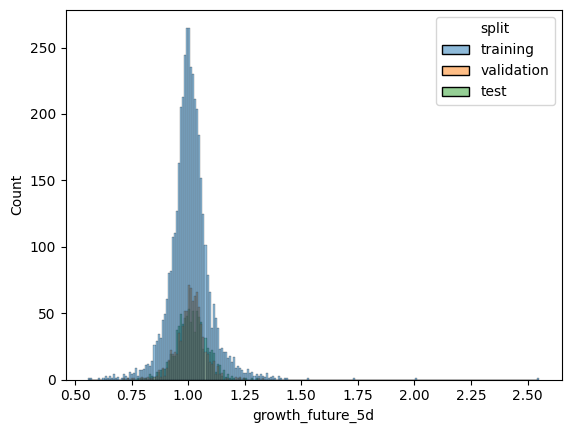

In [21]:
# NVIDIA
nvidia_df = df[df.Ticker == "NVDA"]

sns.histplot(data=nvidia_df, x="growth_future_5d", hue="split")
plt.show()

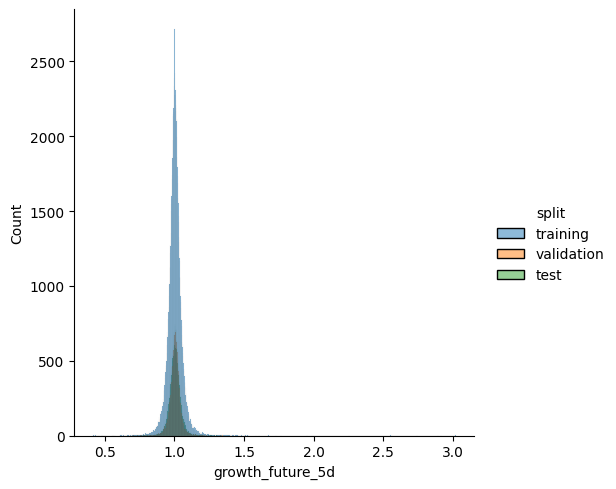

In [22]:
sns.displot(data=df, x="growth_future_5d", hue="split", kind="hist")
plt.show()

In [23]:
df.groupby("split")["growth_future_5d"].describe()

,count,mean,std,min,25%,50%,75%,max
split,,,,,,,,
test,29664.0,1.005015,0.040835,0.690219,0.981994,1.004731,1.027028,1.393477
training,123458.0,1.003965,0.053826,0.412383,0.978474,1.003197,1.028354,3.018887
validation,29388.0,1.004417,0.040642,0.668581,0.985343,1.005120,1.023999,1.459217


From the histogram and summary statistics, all tickers produce a similar distribution across the split. However, there are some outliers on the right-tail on the training set which can hurt the model performance. You may consider removing them as they account for only 1-2% of the training set.

## Model Development

### Heuristic/Rule of Thumbs/Hand Predictions/Naive

Usually we will use this type of model as a baseline. However, in some cases, it might be a good indicator or input to another model or strategy.

Let's say we come up with a great idea that a stock that has the following characteristics will most likely to 5-days future growth. In other words, `is_positive_growth_5d_future` is equal to 1.

* `cci` > 200
* `growth_1d` > 1
* `growth_1d` > 1 and `growth_snp500_1d` > 1

Now we will create a `predict` function to imitate the process of model training and evaluation.

In [24]:
def predict(df):
    """
    Naive prediction.
    """
    prediction_df = df.copy()

    prediction_df["pred0_manual_cci"] = (prediction_df.cci > 200).astype(int)
    prediction_df["pred1_manual_prev_g1"] = (prediction_df.growth_1d > 1).astype(int)
    prediction_df["pred2_manual_prev_g1_and_snp"] = ((prediction_df.growth_1d > 1) & (prediction_df.growth_snp500_1d > 1)).astype(int)

    return prediction_df

Note that although we create all predictions at once, you may select just a few of them based on evaluation process later on.

Also, those predictions don't have to be a binary value. You can create a numerical values from descriptive statistics or your own technical indicators using the existing ones!

In [25]:
df = predict(df)

Next, we check that our predictions are correct via prediction labelling process. After that we evaluate our model based on selection metrics on a test set. For stock market analytics, it has the common metrics as the following:

* Binary classification: Precision (Long) and Accuracy (Long and Short)
* Regression: RMSE

In this case of spot trading, we will use precision.

In [26]:
# Label prediction
df["is_correct_pred0"] = df.pred0_manual_cci == df.is_positive_growth_5d_future
df["is_correct_pred1"] = df.pred1_manual_prev_g1 == df.is_positive_growth_5d_future
df["is_correct_pred2"] = df.pred2_manual_prev_g1_and_snp == df.is_positive_growth_5d_future

In [27]:
# Precision: the percentage of "correct" predictions
print(df.loc[(df["split"] == "test") & (df["pred0_manual_cci"] == 1), "is_correct_pred0"].value_counts(normalize=True))
print(df.loc[(df["split"] == "test") & (df["pred1_manual_prev_g1"] == 1), "is_correct_pred1"].value_counts(normalize=True))
print(df.loc[(df["split"] == "test") & (df["pred2_manual_prev_g1_and_snp"] == 1), "is_correct_pred2"].value_counts(normalize=True))

is_correct_pred0
True     0.569462
False    0.430538
Name: proportion, dtype: float64
is_correct_pred1
True     0.552593
False    0.447407
Name: proportion, dtype: float64
is_correct_pred2
True     0.547681
False    0.452319
Name: proportion, dtype: float64


In [28]:
# Absolute predictions
print(df.loc[(df["split"] == "test") & (df["pred0_manual_cci"] == 1), "is_correct_pred0"].value_counts())
print(df.loc[(df["split"] == "test") & (df["pred1_manual_prev_g1"] == 1), "is_correct_pred1"].value_counts())
print(df.loc[(df["split"] == "test") & (df["pred2_manual_prev_g1_and_snp"] == 1), "is_correct_pred2"].value_counts())

is_correct_pred0
True     455
False    344
Name: count, dtype: int64
is_correct_pred1
True     8621
False    6980
Name: count, dtype: int64
is_correct_pred2
True     5726
False    4729
Name: count, dtype: int64


Note that the number of samples for `is_correct_pred0` is not very high. Therefore, the confidence of around 57% precision on `cci` > 200 may not reliable.

### Statistical Model

For the statistical model and ML model, we will train on *NVIDIA* only. However, it is compatible for all tickers.

#### ARIMA

*ARIMA* is a fundametal statistical model making use of its lag values to estimate (extrapolate) over time. It is considered a good approach when you want to build a general model such as FED rate or GDP. It also offer more explainability compared to ML model, which some of them may have its own advantage in this aspect like feature importance. There are several statistical models that can be used too such as *ARCH/GARCH* and *VAR*.

In the following we prepare `train_df` using "training" and "validation" from the earlier snippet. Both training and validation set are the dataset that *ARIMA* will train on and tune the hyperparameters to come up with the best model.

In [29]:
# Model on NVIDIA
nvidia_df = df[df.Ticker == "NVDA"].set_index("Date")

# Data splitting
train_df = nvidia_df.loc[nvidia_df["split"].isin(["training", "validation"]), "Adj Close_x"]
test_df = nvidia_df.loc[nvidia_df["split"].isin(["test"]), "Adj Close_x"]

##### Model Training

We'll use [`auto_arima`](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html) function in `pmdarima` library to perform a search that has the set of `p`, `q` and `d` which has the lowest AIC.

In [30]:
# https://miqbalrp.medium.com/exploring-autoarima-in-python-for-multiple-time-series-forecasting-2f3004ba5a49
# Setup minimum and maximum p and q; auto determination for d to find the optimum parameters using AIC
best_arima_model = auto_arima(
    train_df, 
    seasonal=False, 
    trace=True, 
    start_p=0, start_q=0, 
    max_p=12, max_q=12, 
    D=None
)

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=16117.745, Time=0.06 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=13788.023, Time=0.36 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.08 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=16115.745, Time=0.04 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=13156.447, Time=0.34 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=12904.465, Time=0.40 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=12644.563, Time=0.55 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=12599.133, Time=0.62 sec
 ARIMA(6,2,0)(0,0,0)[0] intercept   : AIC=12198.216, Time=0.93 sec
 ARIMA(7,2,0)(0,0,0)[0] intercept   : AIC=12199.408, Time=1.45 sec
 ARIMA(6,2,1)(0,0,0)[0] intercept   : AIC=11632.146, Time=4.38 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=5.08 sec
 ARIMA(7,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=6.42 sec
 ARIMA(6,2,2)(0,0,0)[0] intercept   : AIC=11577.217, Time=5.13 sec
 ARIMA(5,2,2)(0,0,0)[0] intercept   :

In [31]:
best_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 5207
Model:               SARIMAX(6, 2, 2)   Log Likelihood               -5778.609
Date:                Thu, 30 May 2024   AIC                          11577.217
Time:                        14:00:50   BIC                          11642.791
Sample:                             0   HQIC                         11600.153
                               - 5207                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    8.92e-05      0.000      0.299      0.765      -0.000       0.001
ar.L1         -0.8248      0.014    -61.012      0.000      -0.851      -0.798
ar.L2         -0.0431      0.005     -8.665      0.000      -0.053      -0.033
ar.L3          0.0440      0.005      9.351      0.000       0.035       0.053
ar.L4         -0.0350      0.006     -5.725      0.000      -0.047      -0.023
ar.L5         -0.0586      0.006     -9.060      0.000      -0.071      -0.046
ar.L6         -0.1420      0.005    -25.953      0.000      -0.153      -0.131
ma.L1         -0.2838      0.013    -21.413      0.000      -0.310      -0.258
ma.L2         -0.6912      0.013    -51.916      0.000      -0.717      -0.665
sigma2         0.5575      0.003    220.936      0.000       0.553       0.562
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):            737252.10
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):             128.84   Skew:                            -2.25
Prob(H) (two-sided):                  0.00   Kurtosis:                        61.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [32]:
best_order = best_arima_model.get_params()["order"]
print(f"The best order for ARIMA model: {best_order}")

The best order for ARIMA model: (6, 2, 2)


##### Model Evaluation

For model evaluation in *ARIMA*, we'll do something called "walk-forward validation". This is related to the real-world situation when there is a new time-step coming in the next day (or next minute), we are likely to use it to train a new model based on the optimum parameters on model training process and use it to make a prediction. Then, we evaluate those prediction(s) with the actual ones and we repeat the process for every step in the test set.

In this example, we'll imagine that each timestep in test set are incoming data which will be updated daily and our goal is to validate is it going to have a return in the 5-days based on that day prediction?

In [33]:
# https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
def rolling_forecast(history, test, best_order, look_forward):
    """
    Rolling forecast for binary classification.
    """
    output = list()    
    predictions = list()

    # Validate on each timestep
    for t in range(len(test)):

        # Retrain a model
        print(f"Training on step {t}...")
        model = ARIMA(order=best_order)
        model.fit(history)

        # Forecast
        forecast = model.predict(n_periods=look_forward)[look_forward - 1]

        # Prediction
        latest = history[-1]
        prediction = 1 if forecast > latest else 0

        # Update history for retraining as daily incoming data
        history.append(test[t])
        
        # Update output and prediction
        output.append(forecast)
        predictions.append(prediction)

    return output, predictions

Note that there is a [original version of rolling forecast](./Module_3_Colab_Time_Series_Modeling.ipynb) from the lecture.

In [34]:
# Predictions
history = train_df.tolist()

timesteps = 50
test = test_df.tolist()[:timesteps] # first few records

look_forward = 5
output, predictions = rolling_forecast(history, test, best_order, look_forward=look_forward)

Training on step 0...


/Users/green/miniforge3/envs/stock-market-analytics-zoomcamp/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Training on step 1...


/Users/green/miniforge3/envs/stock-market-analytics-zoomcamp/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Training on step 2...


/Users/green/miniforge3/envs/stock-market-analytics-zoomcamp/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Training on step 3...


/Users/green/miniforge3/envs/stock-market-analytics-zoomcamp/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Training on step 4...


/Users/green/miniforge3/envs/stock-market-analytics-zoomcamp/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Training on step 5...


/Users/green/miniforge3/envs/stock-market-analytics-zoomcamp/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Training on step 6...


/Users/green/miniforge3/envs/stock-market-analytics-zoomcamp/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Training on step 7...


/Users/green/miniforge3/envs/stock-market-analytics-zoomcamp/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Training on step 8...


/Users/green/miniforge3/envs/stock-market-analytics-zoomcamp/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Training on step 9...


/Users/green/miniforge3/envs/stock-market-analytics-zoomcamp/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Training on step 10...


/Users/green/miniforge3/envs/stock-market-analytics-zoomcamp/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Training on step 11...


/Users/green/miniforge3/envs/stock-market-analytics-zoomcamp/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Training on step 12...


/Users/green/miniforge3/envs/stock-market-analytics-zoomcamp/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Training on step 13...


/Users/green/miniforge3/envs/stock-market-analytics-zoomcamp/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Training on step 14...


/Users/green/miniforge3/envs/stock-market-analytics-zoomcamp/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Training on step 15...


/Users/green/miniforge3/envs/stock-market-analytics-zoomcamp/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Training on step 16...


/Users/green/miniforge3/envs/stock-market-analytics-zoomcamp/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Training on step 17...


/Users/green/miniforge3/envs/stock-market-analytics-zoomcamp/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Training on step 18...


/Users/green/miniforge3/envs/stock-market-analytics-zoomcamp/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Training on step 19...


/Users/green/miniforge3/envs/stock-market-analytics-zoomcamp/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Training on step 20...


/Users/green/miniforge3/envs/stock-market-analytics-zoomcamp/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Training on step 21...


/Users/green/miniforge3/envs/stock-market-analytics-zoomcamp/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Training on step 22...


/Users/green/miniforge3/envs/stock-market-analytics-zoomcamp/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Training on step 23...


/Users/green/miniforge3/envs/stock-market-analytics-zoomcamp/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Training on step 24...


/Users/green/miniforge3/envs/stock-market-analytics-zoomcamp/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Training on step 25...


/Users/green/miniforge3/envs/stock-market-analytics-zoomcamp/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Training on step 26...


/Users/green/miniforge3/envs/stock-market-analytics-zoomcamp/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Training on step 27...


/Users/green/miniforge3/envs/stock-market-analytics-zoomcamp/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Training on step 28...


/Users/green/miniforge3/envs/stock-market-analytics-zoomcamp/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Training on step 29...


/Users/green/miniforge3/envs/stock-market-analytics-zoomcamp/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Training on step 30...


/Users/green/miniforge3/envs/stock-market-analytics-zoomcamp/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Training on step 31...


/Users/green/miniforge3/envs/stock-market-analytics-zoomcamp/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Training on step 32...


/Users/green/miniforge3/envs/stock-market-analytics-zoomcamp/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Training on step 33...


/Users/green/miniforge3/envs/stock-market-analytics-zoomcamp/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Training on step 34...


/Users/green/miniforge3/envs/stock-market-analytics-zoomcamp/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Training on step 35...


/Users/green/miniforge3/envs/stock-market-analytics-zoomcamp/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Training on step 36...


/Users/green/miniforge3/envs/stock-market-analytics-zoomcamp/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Training on step 37...


/Users/green/miniforge3/envs/stock-market-analytics-zoomcamp/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Training on step 38...


/Users/green/miniforge3/envs/stock-market-analytics-zoomcamp/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Training on step 39...


/Users/green/miniforge3/envs/stock-market-analytics-zoomcamp/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Training on step 40...


/Users/green/miniforge3/envs/stock-market-analytics-zoomcamp/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Training on step 41...


/Users/green/miniforge3/envs/stock-market-analytics-zoomcamp/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Training on step 42...


/Users/green/miniforge3/envs/stock-market-analytics-zoomcamp/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Training on step 43...


/Users/green/miniforge3/envs/stock-market-analytics-zoomcamp/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Training on step 44...


/Users/green/miniforge3/envs/stock-market-analytics-zoomcamp/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Training on step 45...


/Users/green/miniforge3/envs/stock-market-analytics-zoomcamp/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Training on step 46...


/Users/green/miniforge3/envs/stock-market-analytics-zoomcamp/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Training on step 47...


/Users/green/miniforge3/envs/stock-market-analytics-zoomcamp/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Training on step 48...


/Users/green/miniforge3/envs/stock-market-analytics-zoomcamp/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Training on step 49...


/Users/green/miniforge3/envs/stock-market-analytics-zoomcamp/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [35]:
# Actual situations
actuals = [nvidia_df.loc[nvidia_df["split"].isin(["training"]), "is_positive_growth_5d_future"].tolist()[-1]] + nvidia_df.loc[nvidia_df["split"].isin(["test"]), "is_positive_growth_5d_future"].tolist()[:timesteps - 1]

# Correct decisions
is_corrects = [prediction == actual for prediction, actual in zip(predictions, actuals)]

In [36]:
# Metrics: precision
tp = 0
fp = 0
for prediction, is_correct in zip(predictions, is_corrects):
    if prediction == 1:
        if is_correct:
            tp += 1
        else:
            fp += 1

print(f"Precision: {tp / (tp + fp):.2%}")

Precision: 46.94%


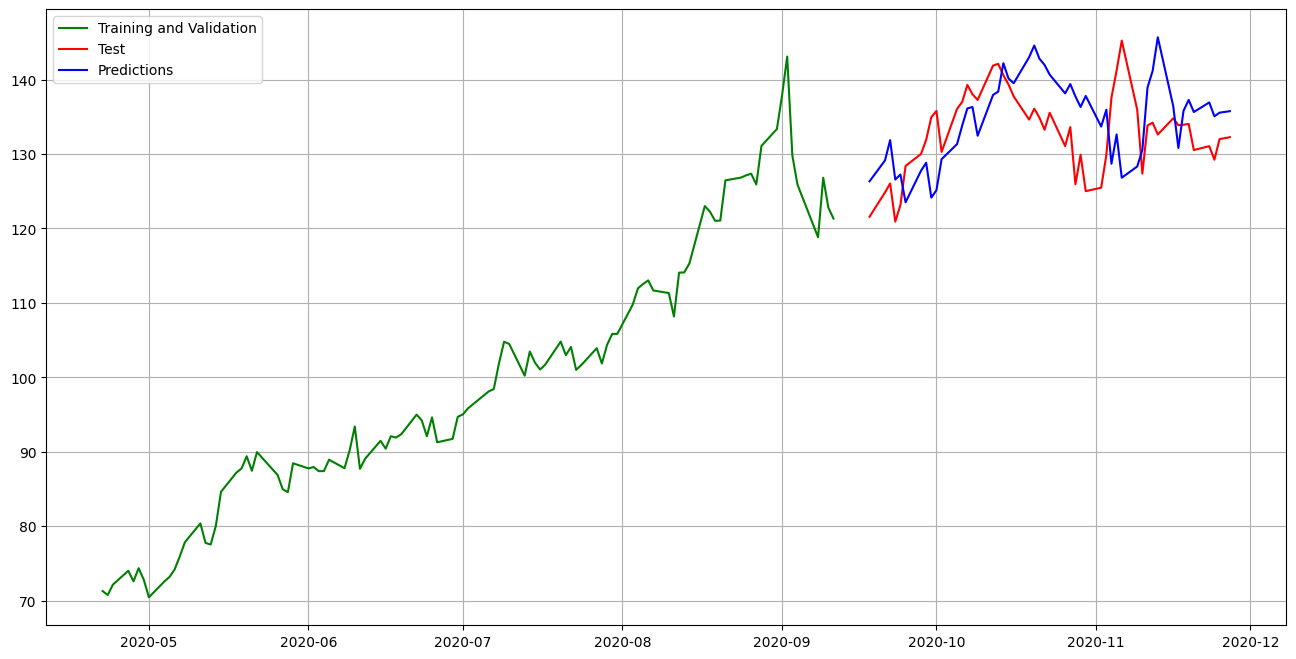

In [37]:
plt.figure(figsize=(16, 8))
plt.plot(train_df.index[-100:], train_df.tail(100), color="green", label="Training and Validation")
plt.plot(test_df.index[look_forward - 1:timesteps + look_forward - 1], test_df.iloc[look_forward - 1:timesteps + look_forward - 1].tolist(), color="red", label="Test")
plt.plot(test_df.index[look_forward - 1:timesteps + look_forward - 1], output, color="blue", label="Predictions")

plt.grid(True)
plt.legend()
plt.show()

### ML Model

#### Decision Tree

##### Data Preparation

The first step in any ML model is to prepare data for the algorithm. We've already prepare some of them such as feature encoding. To quickly investigate on other issues we can use data visualization or descriptive statistics.

In [38]:
df[TARGETS + NUMERICAL_FEATURES + DUMMIES].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182675 entries, 0 to 182674
Columns: 241 entries, growth_future_5d to ticker_type_US
dtypes: float64(122), int32(117), int64(2)
memory usage: 254.4 MB


In [39]:
pd.set_option('display.max_columns', None)
df[NUMERICAL_FEATURES + DUMMIES + TARGETS].describe()

,growth_1d,growth_3d,growth_7d,growth_30d,growth_90d,growth_365d,growth_dax_1d,growth_dax_3d,growth_dax_7d,growth_dax_30d,growth_dax_90d,growth_dax_365d,growth_snp500_1d,growth_snp500_3d,growth_snp500_7d,growth_snp500_30d,growth_snp500_90d,growth_snp500_365d,growth_dji_1d,growth_dji_3d,growth_dji_7d,growth_dji_30d,growth_dji_90d,growth_dji_365d,growth_epi_1d,growth_epi_3d,growth_epi_7d,growth_epi_30d,growth_epi_90d,growth_epi_365d,growth_gold_1d,growth_gold_3d,growth_gold_7d,growth_gold_30d,growth_gold_90d,growth_gold_365d,growth_wti_oil_1d,growth_wti_oil_3d,growth_wti_oil_7d,growth_wti_oil_30d,growth_wti_oil_90d,growth_wti_oil_365d,growth_brent_oil_1d,growth_brent_oil_3d,growth_brent_oil_7d,growth_brent_oil_30d,growth_brent_oil_90d,growth_brent_oil_365d,growth_btc_usd_1d,growth_btc_usd_3d,growth_btc_usd_7d,growth_btc_usd_30d,growth_btc_usd_90d,growth_btc_usd_365d,gdppot_us_yoy,gdppot_us_qoq,cpi_core_yoy,cpi_core_mom,FEDFUNDS,DGS1,DGS5,DGS10,adx,adxr,apo,aroon_1,aroon_2,aroonosc,bop,cci,cmo,dx,macd,macdsignal,macdhist,macd_ext,macdsignal_ext,macdhist_ext,macd_fix,macdsignal_fix,macdhist_fix,mfi,minus_di,mom,plus_di,dm,ppo,roc,rocp,rocr,rocr100,rsi,slowk,slowd,fastk,fastd,fastk_rsi,fastd_rsi,trix,ultosc,willr,ad,adosc,obv,atr,natr,ht_dcperiod,ht_dcphase,ht_phasor_inphase,ht_phasor_quadrature,ht_sine_sine,ht_sine_leadsine,ht_trendmod,avgprice,medprice,typprice,wclprice,cdl2crows,cdl3blackrows,cdl3inside,cdl3linestrike,cdl3outside,cdl3starsinsouth,cdl3whitesoldiers,cdlabandonedbaby,cdladvancedblock,cdlbelthold,cdlbreakaway,cdlclosingmarubozu,cdlconcealbabyswall,cdlcounterattack,cdldarkcloudcover,cdldoji,cdldojistar,cdldragonflydoji,cdlengulfing,cdleveningdojistar,cdleveningstar,cdlgapsidesidewhite,cdlgravestonedoji,cdlhammer,cdlhangingman,cdlharami,cdlharamicross,cdlhighwave,cdlhikkake,cdlhikkakemod,cdlhomingpigeon,cdlidentical3crows,cdlinneck,cdlinvertedhammer,cdlkicking,cdlkickingbylength,cdlladderbottom,cdllongleggeddoji,cdllongline,cdlmarubozu,cdlmatchinglow,cdlmathold,cdlmorningdojistar,cdlmorningstar,cdlonneck,cdlpiercing,cdlrickshawman,cdlrisefall3methods,cdlseparatinglines,cdlshootingstar,cdlshortline,cdlspinningtop,cdlstalledpattern,cdlsticksandwich,cdltakuru,cdltasukigap,cdlthrusting,cdltristar,cdlunique3river,cdlupsidegap2crows,cdlxsidegap3methods,SMA10,SMA20,growing_moving_average,high_minus_low_relative,volatility,LN_Volume,Month_April,Month_August,Month_December,Month_February,Month_January,Month_July,Month_June,Month_March,Month_May,Month_November,Month_October,Month_September,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6,Ticker_AAPL,Ticker_ACN,Ticker_AMZN,Ticker_ASML,Ticker_AVGO,Ticker_BHARTIARTL.NS,Ticker_BRK-B,Ticker_CDI.PA,Ticker_GOOG,Ticker_HDB,Ticker_HINDUNILVR.NS,Ticker_IBN,Ticker_IDEXY,Ticker_INFY,Ticker_ITC.NS,Ticker_JPM,Ticker_LICI.NS,Ticker_LLY,Ticker_LT.NS,Ticker_MC.PA,Ticker_META,Ticker_MSFT,Ticker_NVDA,Ticker_NVO,Ticker_OR.PA,Ticker_RELIANCE.NS,Ticker_RMS.PA,Ticker_SAP,Ticker_SBIN.NS,Ticker_SIE.DE,Ticker_TCS.NS,Ticker_TTE,Ticker_V,ticker_type_EU,ticker_type_INDIA,ticker_type_US,growth_future_5d,is_positive_growth_5d_future
count,182660.000000,182630.000000,182570.000000,182225.000000,181325.000000,176915.000000,179673.000000,179673.000000,179673.000000,179673.000000,179673.000000,179673.000000,180522.000000,180522.000000,180522.000000,180522.000000,180522.000000,180522.000000,180522.000000,180522.000000,180522.000000,180522.000000,180522.000000,180522.000000,127334.000000,127278.000000,127166.000000,126527.000000,124820.000000,116981.000000,176407.000000,176363.000000,176275.000000,175769.000000,174449.000000,168127.000000,176633.000000,176589.000000,176501.000000,175995.000000,174675.000000,168363.000000,129535.000000,129479.000000,129367.000000,128730.000000,127064.000000,119289.000000,77901.000000,77837.000000,77773.000000,77251.000000,75955.000000,69900.000000,182675.000000,182675.000000,182675.000000,182675.000000,182675.000000,182675.000000,182675.000000,182675.000000,182

From the information, we will know there are some missing values in most of the growth columns. The reason is we use `shift` to calculate both `growth` and `future_growth` and most ML algorithms can not handle missing data. Therefore, we need to preprocess before training the model.

Note that in the summary statistics from the lecture, we'll see the `+inf` and `-inf` in max and min for `LN_Volume` respectively. However, for ours, it doesn't exist anymore as we've already process using `np.where` when we calculate the feature.

In [40]:
# ~100 features with missing data
df.isnull().sum().sort_values(ascending=False).head(100)

growth_btc_usd_365d    112775
growth_btc_usd_90d     106720
growth_btc_usd_30d     105424
growth_btc_usd_7d      104902
growth_btc_usd_3d      104838
                        ...  
roc                       150
rocr                      150
mom                       150
adosc                     135
SMA10                     135
Length: 100, dtype: int64

In our case, it is not feasible to drop missing records because they account for a lot of proportion (both in the number of rows and columns) in our dataset. Instead, we do imputation, which is the process of replacing missing records with some values.

Before we do data imputation, we need to split data first. It is generally a good idea as some method for imputation such as mean imputation can lead to data leakage if the data is not split correctly.

In [41]:
# Data splitting
features = NUMERICAL_FEATURES + DUMMIES
target = TARGETS[1] # binary classification

train_df = df.loc[df.split.isin(["training", "validation"]), [target] + features]
test_df = df.loc[df.split.isin(["test"]), [target] + features]

After that we can impute the data. In this case, there is no difference between when you split the data because we impute `NaN` with 0.

In [42]:
# Simple imputation
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

##### Model Training

In [43]:
X_train = train_df[features]
y_train = train_df[target]

print(f"Faeture spaces: {X_train.shape}")
print(f"Target space: {y_train.shape}")

Faeture spaces: (152846, 239)
Target space: (152846,)


In [45]:
clf = DecisionTreeClassifier(max_depth=20, random_state=42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=20, random_state=42)

Note that in most algorithms we have to remove outliers as they may lower model performance. Due to its nature of tree-based models, we can ignore this process. The reason is that the calculation of split nodes is based on the majority vote. Therefore, even you have a few outliers they won't affect the performance that much.

Also, in practice we usually use "validation" set for tuning the model, which is the process of empirically choosing hyperparameters for finding the most performed model.

##### Model Evaluation

In [46]:
X_test = test_df[features]
y_test = test_df[target]

print(f"Faeture spaces: {X_test.shape}")
print(f"Target space: {y_test.shape}")

Faeture spaces: (29829, 239)
Target space: (29829,)


In [47]:
y_pred = clf.predict(X_test)

In [48]:
prec = precision_score(y_test, y_pred)
print(f"Precision: {prec:.2%}")

Precision: 55.84%


##### Tree Visualization and Feature Importance

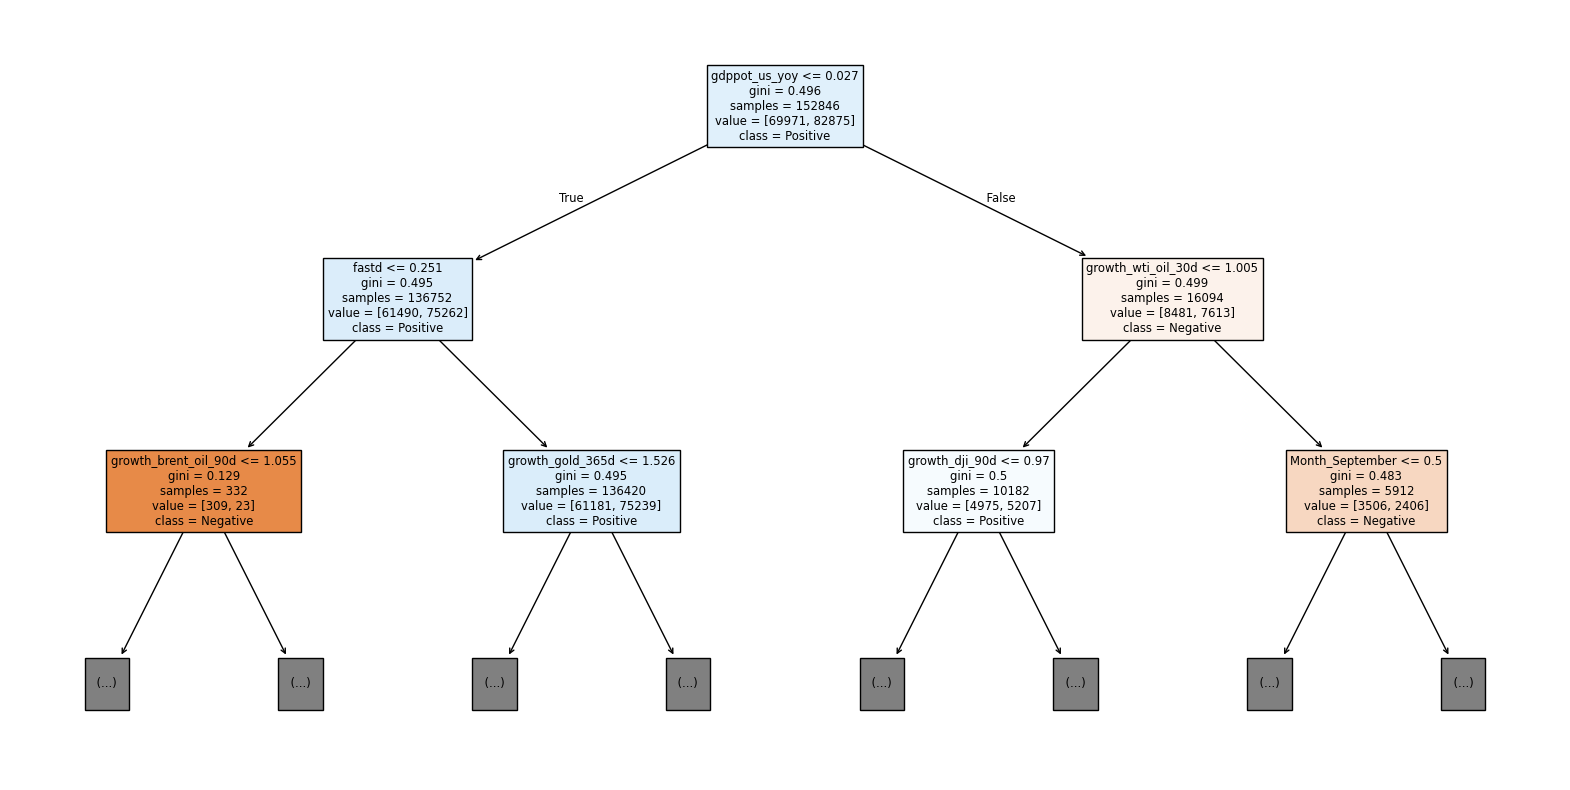

In [49]:
# Tree visualization
plt.figure(figsize=(20, 10))
plot_tree(
    clf, 
    filled=True, 
    feature_names=clf.feature_names_in_, 
    class_names=["Negative", "Positive"], # [0, 1]
    max_depth=2
)

plt.show()

Note that in the visualization each node represent data as the following:

* `feature` used to split the node and its split point
* `gini`, which is the impurity of the split, the lower the value is, the more distinct the feature to become the split is
* `samples` is the total number of examples in the node
* `value` are the number of examples on each class
* `class` identifies which category is the majority of the node

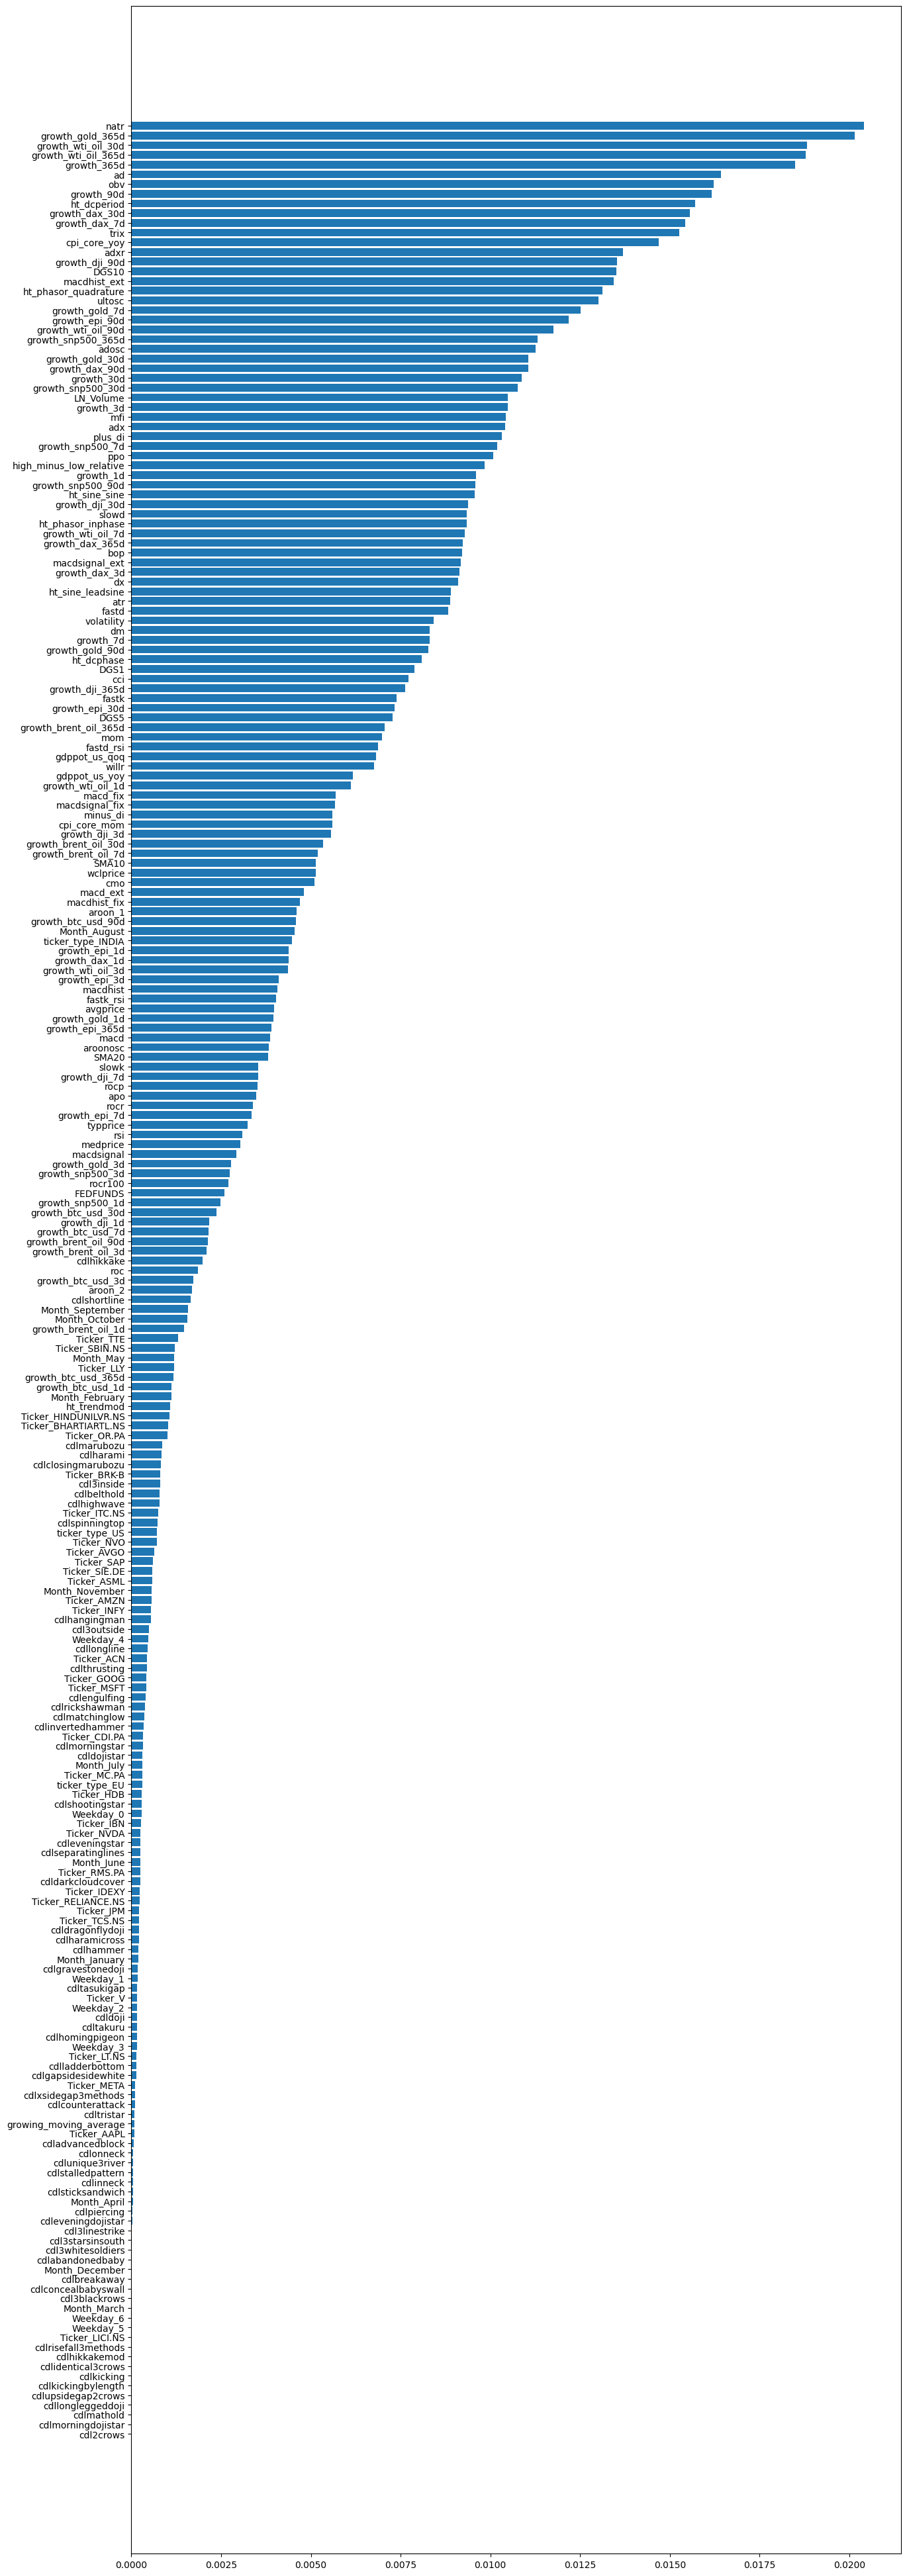

In [50]:
# Feature importance
importance_df = pd.DataFrame({"feature": clf.feature_names_in_, "importance": clf.feature_importances_}).sort_values(by="importance", ascending=True)

plt.figure(figsize=(15, 50))
plt.barh(importance_df["feature"], importance_df["importance"])
plt.show()

Tree visualization helps you better understand what the model is doing. Whereas, the feature importance assists in feature selection.

For ease of use, we can calculate the prediction for the entire dataframe and save it as a single-file dataframe.

In [51]:
X_pred = df[features]
y_pred = clf.predict(X_pred)

df["pred_tree_clf10"] = y_pred

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182675 entries, 0 to 182674
Columns: 266 entries, Open to pred_tree_clf10
dtypes: bool(3), datetime64[ns](2), float64(129), int32(118), int64(9), object(5)
memory usage: 284.8+ MB
